# Auto Encoder

## Load Dataset

In [1]:
DATASET_NAME = 'dataset-5000'
TEST_DATASET_NAME = 'dataset-test'
BATCH_SIZE = 16
MODEL_PATH = 'model/cnn'

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from util import GeneratedDataset

trainset = GeneratedDataset(DATASET_NAME, transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = GeneratedDataset(TEST_DATASET_NAME, transforms.ToTensor())
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

## Define CNN based auto-encoder

- 64 * 64 * 3 image input = 12,288
- Cov3 with 32 channel, 3 * 3 * 3 * 32 = 864 parameters
- ReLU
- MaxPool -> 32 * 32 * 32 hidden state = 32768
- Cov3 with 64 channel, 32 * 3 * 3 * 64 = 18432 parameters
- ReLU
- MaxPool -> 16 * 16 * 64 hidden state = 16384
- Cov3 with 128 channel, 64 * 3 * 3 * 128 = 73728 parameters
- ReLU
- MaxPool -> 8 * 8 * 128 = 8192 hidden state
- Full connected 8192 -> **embedding size**

And the decoder works reversely.

In [2]:
# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, embedding_size=32):
        super(Autoencoder, self).__init__()
        self.embedding_size = embedding_size
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.fc1 = nn.Linear(8 * 8 * 128, self.embedding_size)  # Fully connected layer to get 32-length embedding

        # Decoder
        self.fc2 = nn.Linear(self.embedding_size, 8 * 8 * 128)  # Fully connected layer to reshape back to 8x8x128
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)  # Flatten the tensor
        encoded = self.fc1(encoded)  # Get the embedding
        decoded = self.fc2(encoded)  # Reshape back to 8x8x128
        decoded = decoded.view(decoded.size(0), 128, 8, 8)
        decoded = self.decoder(decoded)
        return decoded, encoded

In [3]:
from util import train_model_steps, plot_model, count_parameters

def train_model(embedding_size=32, learning_rate=1e-4, weight_decay=1e-5, num_epochs=20):
    # Initialize the model
    model = Autoencoder(embedding_size=embedding_size)
    print(f'Number of parameters: {count_parameters(model)}')

    model, train_losses, test_losses = train_model_steps(model, trainloader, testloader, learning_rate, weight_decay, num_epochs)
    # Save the model
    torch.save(model.state_dict(), f'{MODEL_PATH}/e{embedding_size}.pth')
    plot_model(model, train_losses, test_losses, testset)
    return model, train_losses, test_losses

## Evaluation

Testing with embedding size of (down from 8192)
- 4
- 8
- 16
- 32
- 64

Number of parameters: 407687
Epoch [1/20], Train Loss: 0.2864, Test Loss: 0.1708
Epoch [2/20], Train Loss: 0.1453, Test Loss: 0.1436
Epoch [3/20], Train Loss: 0.1372, Test Loss: 0.1398
Epoch [4/20], Train Loss: 0.1344, Test Loss: 0.1378
Epoch [5/20], Train Loss: 0.1319, Test Loss: 0.1351
Epoch [6/20], Train Loss: 0.1292, Test Loss: 0.1332
Epoch [7/20], Train Loss: 0.1267, Test Loss: 0.1302
Epoch [8/20], Train Loss: 0.1250, Test Loss: 0.1295
Epoch [9/20], Train Loss: 0.1237, Test Loss: 0.1283
Epoch [10/20], Train Loss: 0.1225, Test Loss: 0.1269
Epoch [11/20], Train Loss: 0.1218, Test Loss: 0.1266
Epoch [12/20], Train Loss: 0.1210, Test Loss: 0.1264
Epoch [13/20], Train Loss: 0.1204, Test Loss: 0.1251
Epoch [14/20], Train Loss: 0.1198, Test Loss: 0.1246
Epoch [15/20], Train Loss: 0.1196, Test Loss: 0.1245
Epoch [16/20], Train Loss: 0.1192, Test Loss: 0.1241
Epoch [17/20], Train Loss: 0.1189, Test Loss: 0.1239
Epoch [18/20], Train Loss: 0.1187, Test Loss: 0.1238
Epoch [19/20], Train Loss:

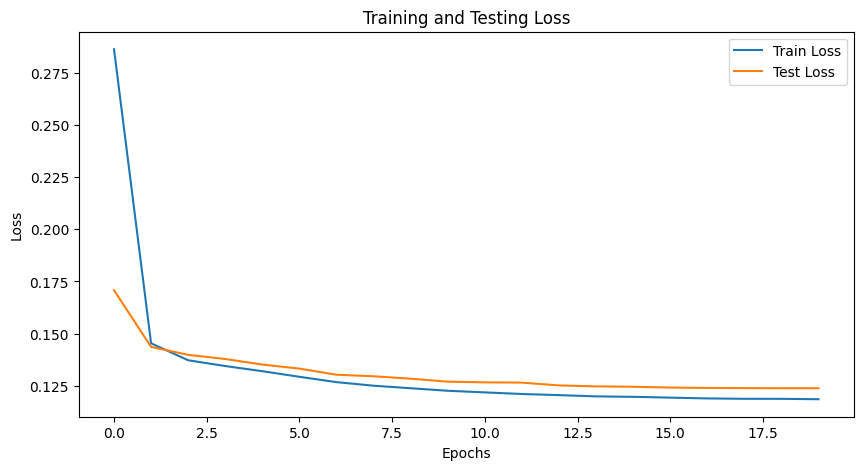

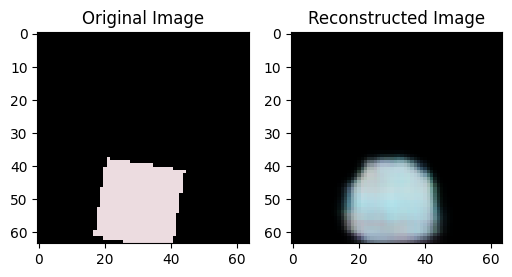

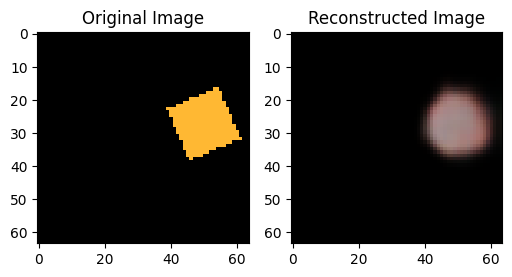

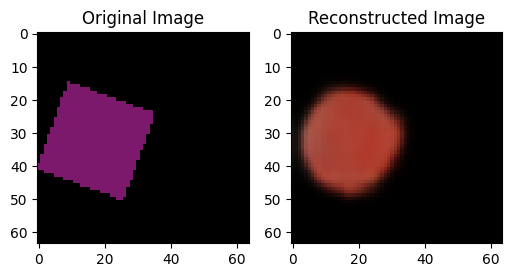

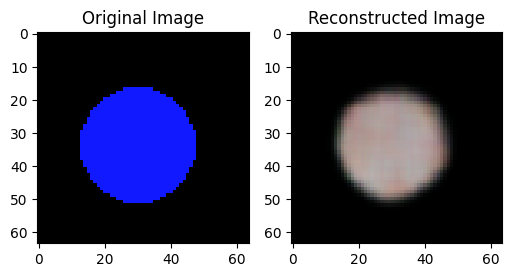

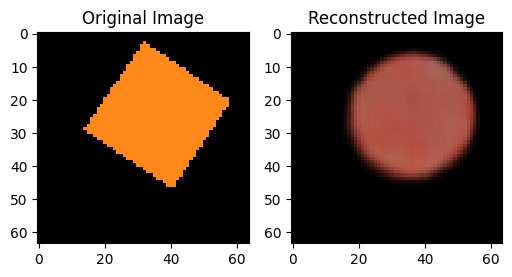

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU()
     (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (fc1): Linear(in_features=8192, out_features=4, bias=True)
   (fc2): Linear(in_features=4, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')
     (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): Upsample(scale_fact

In [4]:
train_model(4)

Number of parameters: 473227
Epoch [1/20], Train Loss: 0.3031, Test Loss: 0.1813
Epoch [2/20], Train Loss: 0.1443, Test Loss: 0.1425
Epoch [3/20], Train Loss: 0.1359, Test Loss: 0.1390
Epoch [4/20], Train Loss: 0.1329, Test Loss: 0.1360
Epoch [5/20], Train Loss: 0.1292, Test Loss: 0.1310
Epoch [6/20], Train Loss: 0.1234, Test Loss: 0.1227
Epoch [7/20], Train Loss: 0.1132, Test Loss: 0.1125
Epoch [8/20], Train Loss: 0.1075, Test Loss: 0.1093
Epoch [9/20], Train Loss: 0.1050, Test Loss: 0.1081
Epoch [10/20], Train Loss: 0.1031, Test Loss: 0.1066
Epoch [11/20], Train Loss: 0.1019, Test Loss: 0.1046
Epoch [12/20], Train Loss: 0.1005, Test Loss: 0.1037
Epoch [13/20], Train Loss: 0.0994, Test Loss: 0.1029
Epoch [14/20], Train Loss: 0.0984, Test Loss: 0.1021
Epoch [15/20], Train Loss: 0.0975, Test Loss: 0.1015
Epoch [16/20], Train Loss: 0.0969, Test Loss: 0.1011
Epoch [17/20], Train Loss: 0.0966, Test Loss: 0.1009
Epoch [18/20], Train Loss: 0.0962, Test Loss: 0.1007
Epoch [19/20], Train Loss:

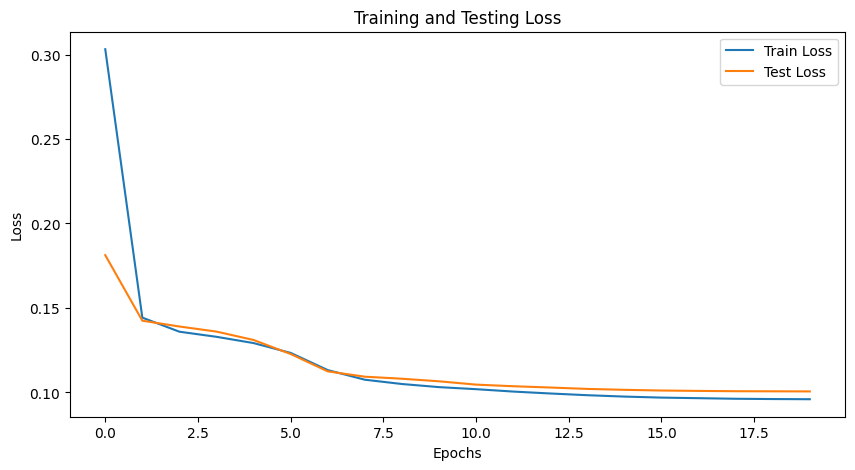

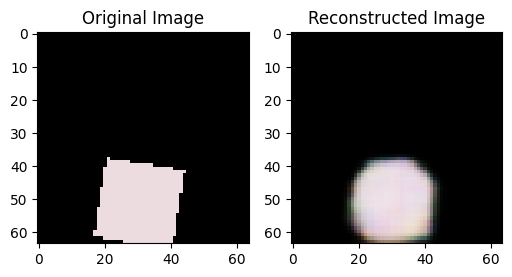

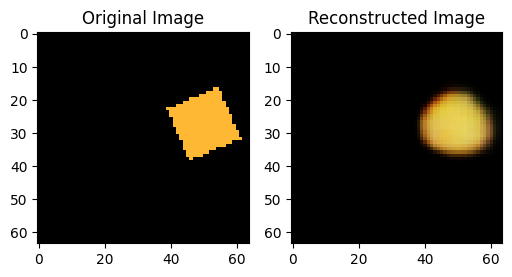

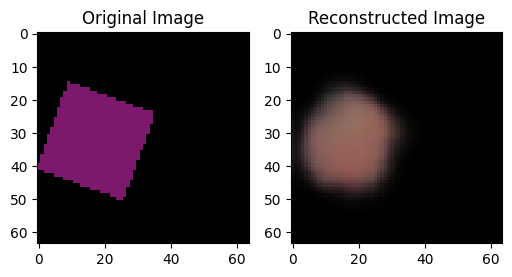

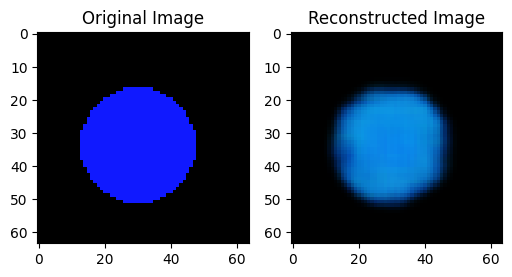

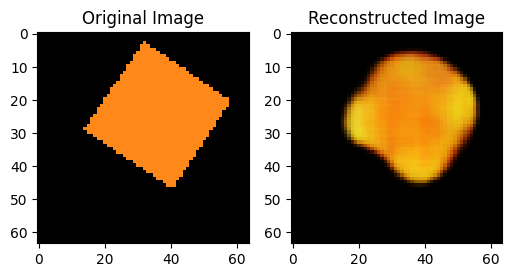

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU()
     (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (fc1): Linear(in_features=8192, out_features=8, bias=True)
   (fc2): Linear(in_features=8, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')
     (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): Upsample(scale_fact

In [5]:
train_model(8)

Number of parameters: 604307
Epoch [1/20], Train Loss: 0.2994, Test Loss: 0.1725
Epoch [2/20], Train Loss: 0.1435, Test Loss: 0.1416
Epoch [3/20], Train Loss: 0.1357, Test Loss: 0.1391
Epoch [4/20], Train Loss: 0.1324, Test Loss: 0.1340
Epoch [5/20], Train Loss: 0.1265, Test Loss: 0.1277
Epoch [6/20], Train Loss: 0.1191, Test Loss: 0.1186
Epoch [7/20], Train Loss: 0.1102, Test Loss: 0.1095
Epoch [8/20], Train Loss: 0.1046, Test Loss: 0.1060
Epoch [9/20], Train Loss: 0.1018, Test Loss: 0.1045
Epoch [10/20], Train Loss: 0.0998, Test Loss: 0.1023
Epoch [11/20], Train Loss: 0.0980, Test Loss: 0.1009
Epoch [12/20], Train Loss: 0.0966, Test Loss: 0.1003
Epoch [13/20], Train Loss: 0.0954, Test Loss: 0.0991
Epoch [14/20], Train Loss: 0.0944, Test Loss: 0.0982
Epoch [15/20], Train Loss: 0.0933, Test Loss: 0.0974
Epoch [16/20], Train Loss: 0.0926, Test Loss: 0.0969
Epoch [17/20], Train Loss: 0.0919, Test Loss: 0.0964
Epoch [18/20], Train Loss: 0.0913, Test Loss: 0.0960
Epoch [19/20], Train Loss:

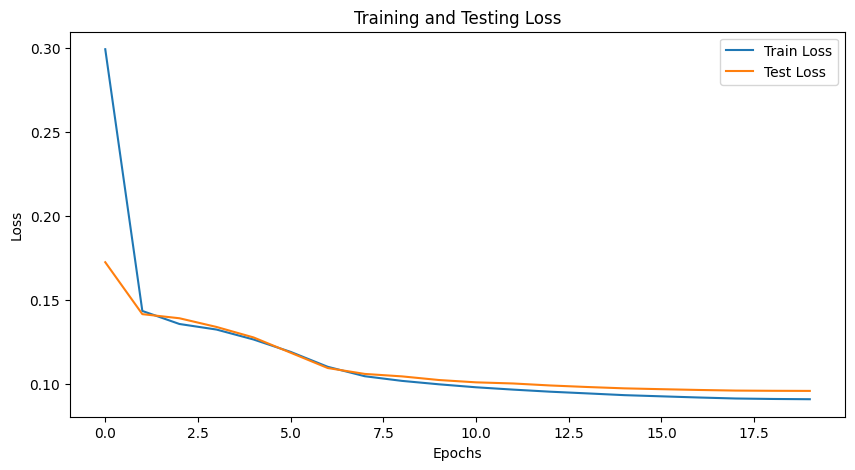

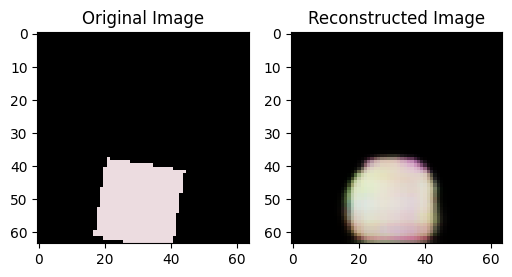

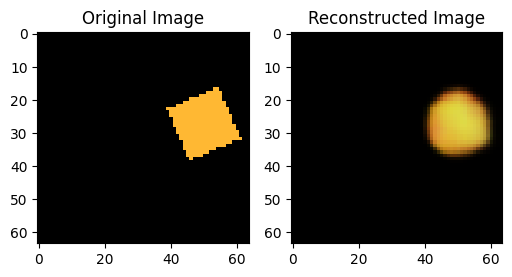

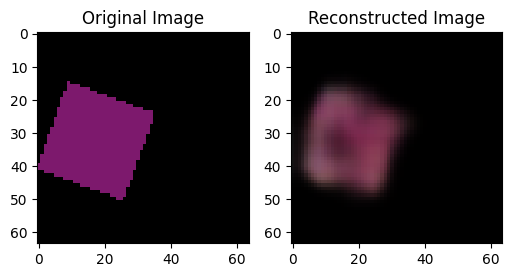

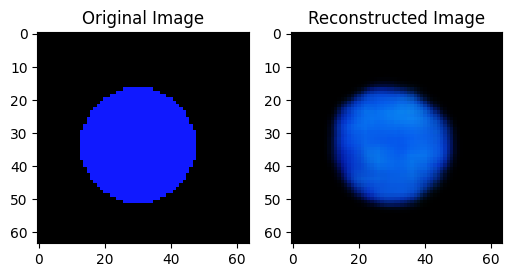

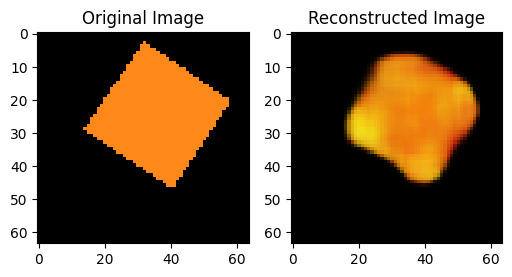

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU()
     (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (fc1): Linear(in_features=8192, out_features=16, bias=True)
   (fc2): Linear(in_features=16, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')
     (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): Upsample(scale_fa

In [6]:
train_model(16)

Number of parameters: 866467
Epoch [1/20], Train Loss: 0.2770, Test Loss: 0.1562
Epoch [2/20], Train Loss: 0.1404, Test Loss: 0.1409
Epoch [3/20], Train Loss: 0.1340, Test Loss: 0.1364
Epoch [4/20], Train Loss: 0.1297, Test Loss: 0.1316
Epoch [5/20], Train Loss: 0.1248, Test Loss: 0.1264
Epoch [6/20], Train Loss: 0.1172, Test Loss: 0.1143
Epoch [7/20], Train Loss: 0.1060, Test Loss: 0.1059
Epoch [8/20], Train Loss: 0.1008, Test Loss: 0.1022
Epoch [9/20], Train Loss: 0.0972, Test Loss: 0.1004
Epoch [10/20], Train Loss: 0.0944, Test Loss: 0.0972
Epoch [11/20], Train Loss: 0.0917, Test Loss: 0.0954
Epoch [12/20], Train Loss: 0.0894, Test Loss: 0.0936
Epoch [13/20], Train Loss: 0.0874, Test Loss: 0.0916
Epoch [14/20], Train Loss: 0.0858, Test Loss: 0.0907
Epoch [15/20], Train Loss: 0.0846, Test Loss: 0.0896
Epoch [16/20], Train Loss: 0.0838, Test Loss: 0.0888
Epoch [17/20], Train Loss: 0.0832, Test Loss: 0.0882
Epoch [18/20], Train Loss: 0.0829, Test Loss: 0.0880
Epoch [19/20], Train Loss:

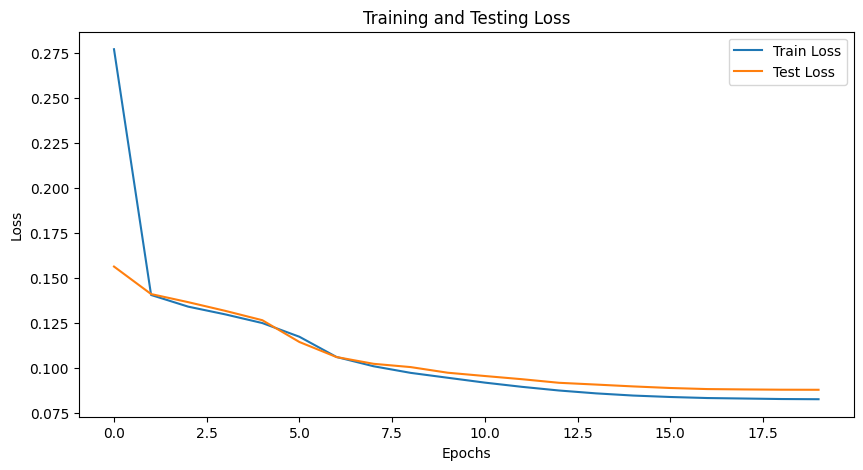

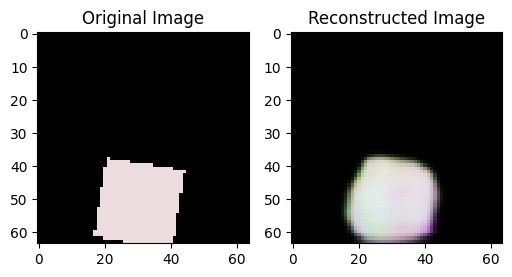

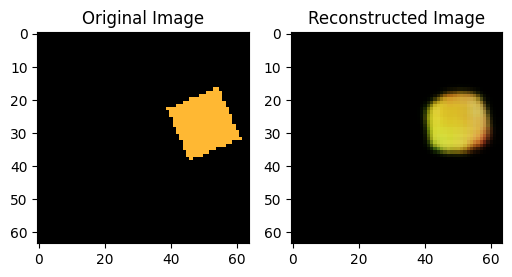

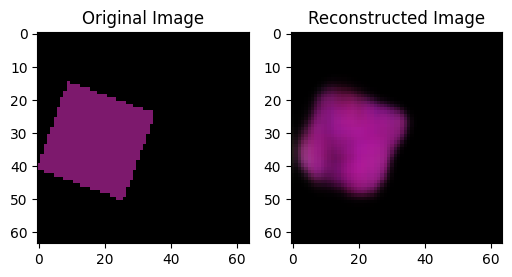

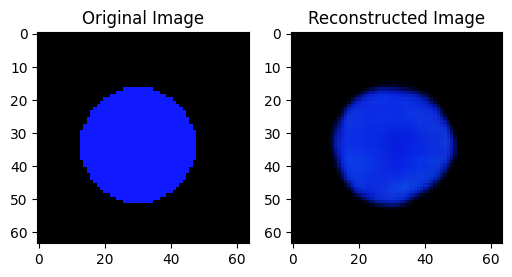

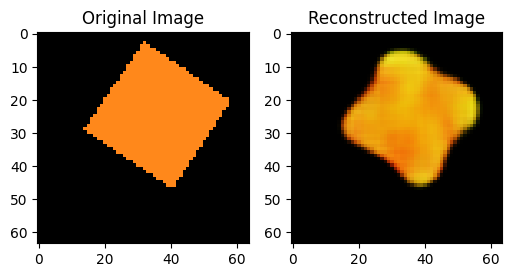

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU()
     (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (fc1): Linear(in_features=8192, out_features=32, bias=True)
   (fc2): Linear(in_features=32, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')
     (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): Upsample(scale_fa

In [7]:
train_model(32)

Number of parameters: 1390787
Epoch [1/20], Train Loss: 0.2877, Test Loss: 0.1548
Epoch [2/20], Train Loss: 0.1410, Test Loss: 0.1401
Epoch [3/20], Train Loss: 0.1333, Test Loss: 0.1344
Epoch [4/20], Train Loss: 0.1271, Test Loss: 0.1278
Epoch [5/20], Train Loss: 0.1173, Test Loss: 0.1137
Epoch [6/20], Train Loss: 0.1063, Test Loss: 0.1074
Epoch [7/20], Train Loss: 0.1021, Test Loss: 0.1057
Epoch [8/20], Train Loss: 0.0995, Test Loss: 0.1024
Epoch [9/20], Train Loss: 0.0968, Test Loss: 0.1008
Epoch [10/20], Train Loss: 0.0943, Test Loss: 0.0974
Epoch [11/20], Train Loss: 0.0916, Test Loss: 0.0955
Epoch [12/20], Train Loss: 0.0887, Test Loss: 0.0925
Epoch [13/20], Train Loss: 0.0865, Test Loss: 0.0907
Epoch [14/20], Train Loss: 0.0851, Test Loss: 0.0896
Epoch [15/20], Train Loss: 0.0842, Test Loss: 0.0888
Epoch [16/20], Train Loss: 0.0835, Test Loss: 0.0883
Epoch [17/20], Train Loss: 0.0831, Test Loss: 0.0880
Epoch [18/20], Train Loss: 0.0828, Test Loss: 0.0878
Epoch [19/20], Train Loss

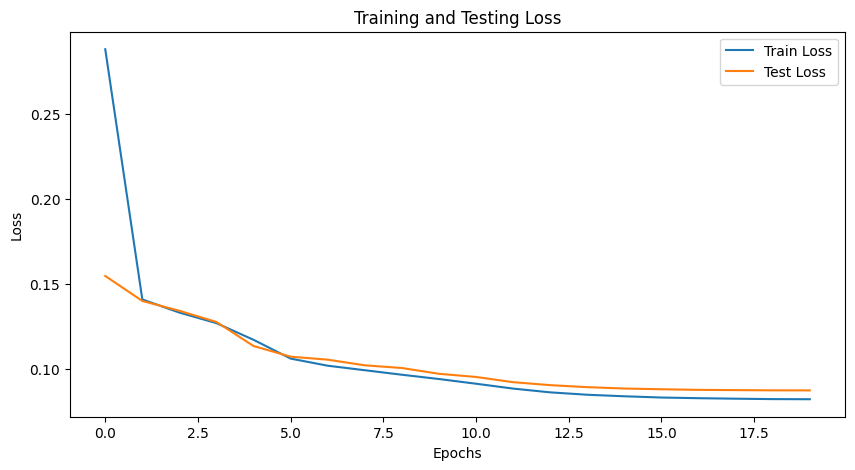

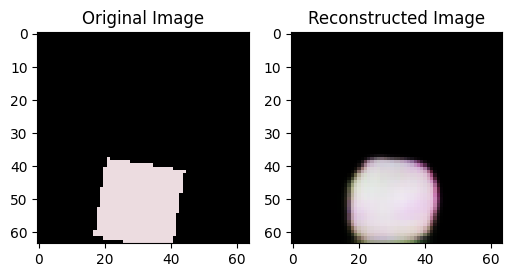

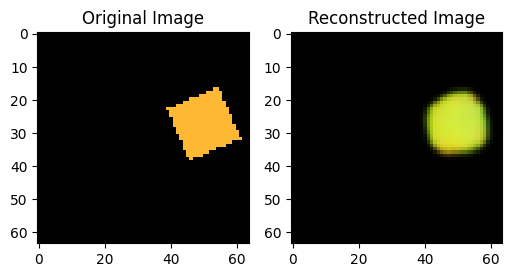

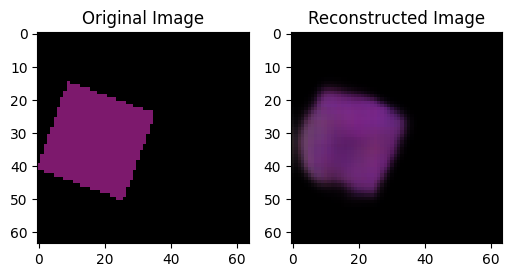

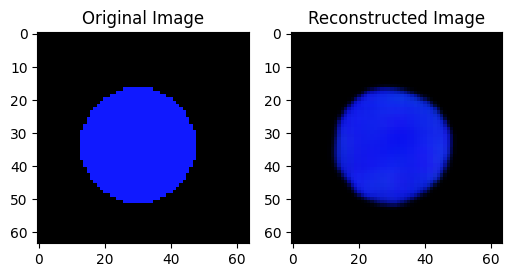

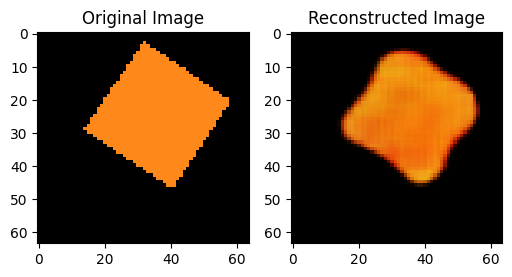

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU()
     (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (fc1): Linear(in_features=8192, out_features=64, bias=True)
   (fc2): Linear(in_features=64, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')
     (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): Upsample(scale_fa

In [8]:
train_model(64)